# Part 1: Build CpG Detector

Here we have a simple problem, given a DNA sequence (of N, A, C, G, T), count the number of CpGs in the sequence (consecutive CGs).

We have defined a few helper functions / parameters for performing this task.

We need you to build a LSTM model and train it to complish this task in PyTorch.

A good solution will be a model that can be trained, with high confidence in correctness.

In [36]:
from typing import Sequence
from functools import partial
import random
import torch
import numpy as np
import random
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt

In [37]:
# DO NOT CHANGE HERE
def set_seed(seed=13):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(13)

# Use this for getting x label
def rand_sequence(n_seqs: int, seq_len: int=128) -> Sequence[int]:
    for i in range(n_seqs):
      yield [random.randint(0, 4) for _ in range(seq_len)]

# Use this for getting y label
def count_cpgs(seq: str) -> int:
    cgs = 0
    for i in range(0, len(seq) - 1):
        dimer = seq[i:i+2]
        # note that seq is a string, not a list
        if dimer == "CG":
            cgs += 1
    return cgs

# Alphabet helpers
alphabet = 'NACGT'
dna2int = { a: i for a, i in zip(alphabet, range(5))}
int2dna = { i: a for a, i in zip(alphabet, range(5))}

intseq_to_dnaseq = partial(map, int2dna.get)
dnaseq_to_intseq = partial(map, dna2int.get)

In [38]:
# we prepared two datasets for training and evaluation
# training data scale we set to 2048
# we test on 512

def prepare_data(num_samples=100):
    # prepared the training and test data
    # you need to call rand_sequence and count_cpgs here to create the dataset
    # step 1
    X_dna_seqs_train = list(rand_sequence(num_samples))
    """
    hint:
        1. You can check X_dna_seqs_train by print, the data is ids which is your training X
        2. You first convert ids back to DNA sequence
        3. Then you run count_cpgs which will yield CGs counts - this will be the labels (Y)
    """
    #step2
    # use intseq_to_dnaseq here to convert ids back to DNA seqs
    temp = [list(intseq_to_dnaseq(x)) for x in X_dna_seqs_train]

    #step3
    # use count_cpgs here to generate labels with temp generated in step2
    y_dna_seqs = [ count_cpgs(seq) for seq in list(map(''.join, temp)) ]

    return X_dna_seqs_train, y_dna_seqs

train_x, train_y = prepare_data(2048)
test_x, test_y = prepare_data(512)

# Convert data to PyTorch tensors
train_x = torch.tensor(train_x)
train_y = torch.tensor(train_y)
test_x = torch.tensor(test_x)
test_y = torch.tensor(test_y)

In [40]:
# some config
LSTM_HIDDEN = 256
LSTM_LAYER = 2
batch_size = 64
learning_rate = 0.001
epoch_num = 50
input_size = 128
output_size = 1

In [41]:
train_data_loader = DataLoader(TensorDataset(train_x, train_y), batch_size=batch_size)
test_data_loader = DataLoader(TensorDataset(test_x, test_y), batch_size=batch_size)

In [42]:
# Model
class CpGPredictor(torch.nn.Module):
    ''' Simple model that uses a LSTM to count the number of CpGs in a sequence '''
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(CpGPredictor, self).__init__()
        # We do need a lstm and a classifier layer here but you are free to implement them in your way
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = torch.nn.Embedding(5, input_size)
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [43]:
# init model / loss function / optimizer etc.
model = CpGPredictor(input_size, LSTM_HIDDEN, LSTM_LAYER, output_size)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [44]:
# training (you can modify the code below)
graph_losses = []
for epoch in range(epoch_num):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_data_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = loss_fn(outputs, batch_y.float().unsqueeze(1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    epoch_loss = total_loss / len(train_data_loader)
    graph_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epoch_num}, Loss: {epoch_loss}")

Epoch 1/50, Loss: 7.462931878864765
Epoch 2/50, Loss: 4.225964397192001
Epoch 3/50, Loss: 4.214828751981258
Epoch 4/50, Loss: 4.209637276828289
Epoch 5/50, Loss: 4.165155239403248
Epoch 6/50, Loss: 4.117880247533321
Epoch 7/50, Loss: 3.636242054402828
Epoch 8/50, Loss: 1.6474030893296003
Epoch 9/50, Loss: 1.0279928967356682
Epoch 10/50, Loss: 0.49530175793915987
Epoch 11/50, Loss: 0.3055695779621601
Epoch 12/50, Loss: 0.17171390331350267
Epoch 13/50, Loss: 0.10172954644076526
Epoch 14/50, Loss: 0.0704089532373473
Epoch 15/50, Loss: 0.05893138510873541
Epoch 16/50, Loss: 0.051715026318561286
Epoch 17/50, Loss: 0.042798469541594386
Epoch 18/50, Loss: 0.03170522241271101
Epoch 19/50, Loss: 0.030158299021422863
Epoch 20/50, Loss: 0.019791809638263658
Epoch 21/50, Loss: 0.0228707153146388
Epoch 22/50, Loss: 0.02527677550096996
Epoch 23/50, Loss: 0.06177614338230342
Epoch 24/50, Loss: 0.07996544876368716
Epoch 25/50, Loss: 0.040764453704468906
Epoch 26/50, Loss: 0.04069132375298068
Epoch 27/

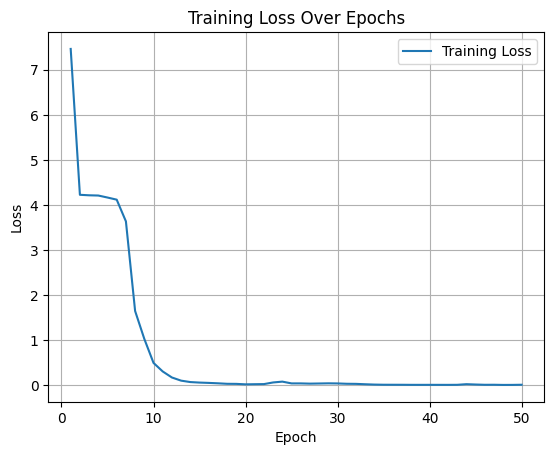

In [45]:
# Plot the loss graph
plt.plot(range(1, epoch_num + 1), graph_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [46]:
# Evaluation
model.eval()
total_loss = 0
with torch.no_grad():
    for batch_x, batch_y in test_data_loader:
        outputs = model(batch_x)
        loss = loss_fn(outputs, batch_y.float().unsqueeze(1))
        total_loss += loss.item()

print(f"Test Loss: {total_loss}")

Test Loss: 0.19586889073252678


In [48]:
# Compute accuracy on new set of test samples by running predictions
N = 100
test_x, test_y = prepare_data(N)

# Convert data to PyTorch tensors
test_x = torch.tensor(test_x)
test_y = torch.tensor(test_y)

# Run predictions for each sequence and compute overall accuracy
correct_predictions = 0
for sequence, y in zip(test_x, test_y):
    # Perform inference
    with torch.no_grad():
        output = model(sequence.unsqueeze(0))
    # Convert output to CpG count
    predicted_cpg_count = output.item()
    # Check if prediction is within a tolerance of 0.5
    if abs(predicted_cpg_count - (y.float().unsqueeze(0))) <= 0.3:
        correct_predictions += 1

# Compute overall accuracy
accuracy = correct_predictions / N
print("Overall Accuracy:", accuracy)

Overall Accuracy: 1.0


In [49]:
torch.save(model.state_dict(), "model.pth")

In [56]:
import random

# Define the list of characters
nucleotides = ['N', 'A', 'C', 'G', 'T']

# Generate a random sequence of 128 characters
random_sequence = ''.join(random.choice(nucleotides) for _ in range(128))

print(random_sequence)
print(count_cpgs(random_sequence))

NGCCTCGAGCNTCCACGACCCAACNGNAGNACGNTCGCGGTCCAGNTACATNCANNACNTCACTNACTCGCNNAGCCGACGTACGTCAGGGGTCNGNANTGNCNNTGGCNCNCNTNACNTCCTTNTGA
9


# Part 2: what if the DNA sequences are not the same length

In [2]:
# hint we will need following imports
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

In [3]:
# DO NOT CHANGE HERE
random.seed(13)

# Use this for getting x label
def rand_sequence_var_len(n_seqs: int, lb: int=16, ub: int=128) -> Sequence[int]:
    for i in range(n_seqs):
        seq_len = random.randint(lb, ub)
        yield [random.randint(1, 5) for _ in range(seq_len)]


# Use this for getting y label
def count_cpgs(seq: str) -> int:
    cgs = 0
    for i in range(0, len(seq) - 1):
        dimer = seq[i:i+2]
        # note that seq is a string, not a list
        if dimer == "CG":
            cgs += 1
    return cgs


# Alphabet helpers
alphabet = 'NACGT'
dna2int = {a: i for a, i in zip(alphabet, range(1, 6))}
int2dna = {i: a for a, i in zip(alphabet, range(1, 6))}
dna2int.update({"pad": 0})
int2dna.update({0: "<pad>"})

intseq_to_dnaseq = partial(map, int2dna.get)
dnaseq_to_intseq = partial(map, dna2int.get)

In [4]:
# TODO complete the task based on the change
def prepare_data(num_samples=100, min_len=16, max_len=128):
    # TODO prepared the training and test data
    # you need to call rand_sequence and count_cpgs here to create the dataset
    #step 1
    X_dna_seqs_train = list(rand_sequence_var_len(num_samples, min_len, max_len))
    #step2
    # use intseq_to_dnaseq here to convert ids back to DNA seqs
    temp = [list(intseq_to_dnaseq(x)) for x in X_dna_seqs_train]

    #step3
    # use count_cpgs here to generate labels with temp generated in step2
    y_dna_seqs = [ count_cpgs(seq) for seq in list(map(''.join, temp)) ]

    return X_dna_seqs_train, y_dna_seqs


min_len, max_len = 64, 128
train_x, train_y = prepare_data(2048, min_len, max_len)
test_x, test_y = prepare_data(512, min_len, max_len)

In [5]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, lists, labels) -> None:
        self.lists = lists
        self.labels = labels

    def __getitem__(self, index):
        return torch.LongTensor(self.lists[index]), self.labels[index]

    def __len__(self):
        return len(self.lists)


# this will be a collate_fn for dataloader to pad sequence
class PadSequence:
    def __init__(self, pad_value=0):
        self.pad_value = pad_value

    def __call__(self, batch):
        max_len = max([len(x[0]) for x in batch])
        batch_x = [torch.LongTensor(list(x[0])  + [self.pad_value] * (max_len - len(x[0]))) for x in batch]  # Convert list to tensor
        batch_y = [x[1] for x in batch]
        return torch.stack(batch_x), torch.LongTensor(batch_y)  # Convert list to tensor

In [6]:
# some config
LSTM_HIDDEN = 256
LSTM_LAYER = 2
batch_size = 64
learning_rate = 0.001
epoch_num = 100
input_size = 128
output_size = 1

In [7]:
# create data loader
train_data_loader = DataLoader(MyDataset(train_x, train_y), batch_size=batch_size, collate_fn=PadSequence())
test_data_loader = DataLoader(MyDataset(test_x, test_y), batch_size=batch_size, collate_fn=PadSequence())

In [8]:
# Model
class CpGPredictor(torch.nn.Module):
    ''' Simple model that uses a LSTM to count the number of CpGs in a sequence '''
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(CpGPredictor, self).__init__()
        # We do need a lstm and a classifier layer here but you are free to implement them in your way
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding = torch.nn.Embedding(6, input_size)
        self.lstm = torch.nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.embedding(x)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [9]:
# init model / loss function / optimizer etc.
model = CpGPredictor(input_size, LSTM_HIDDEN, LSTM_LAYER, output_size)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
# training (you can modify the code below)
graph_losses = []
for epoch in range(epoch_num):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_data_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = loss_fn(outputs, batch_y.float().unsqueeze(1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    epoch_loss = total_loss / len(train_data_loader)
    graph_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epoch_num}, Loss: {epoch_loss}")

Epoch 1/100, Loss: 5.203831508755684
Epoch 2/100, Loss: 3.5823613852262497
Epoch 3/100, Loss: 3.2035830542445183
Epoch 4/100, Loss: 3.080999217927456
Epoch 5/100, Loss: 3.001357316970825
Epoch 6/100, Loss: 2.899892747402191
Epoch 7/100, Loss: 2.2102766148746014
Epoch 8/100, Loss: 1.646355040371418
Epoch 9/100, Loss: 0.9840515162795782
Epoch 10/100, Loss: 0.4077561218291521
Epoch 11/100, Loss: 0.25481847021728754
Epoch 12/100, Loss: 0.21376240719109774
Epoch 13/100, Loss: 0.16722151264548302
Epoch 14/100, Loss: 0.1371768608223647
Epoch 15/100, Loss: 0.1233770017279312
Epoch 16/100, Loss: 0.1489570183912292
Epoch 17/100, Loss: 0.10773756785783917
Epoch 18/100, Loss: 0.10185330011881888
Epoch 19/100, Loss: 0.08107191359158605
Epoch 20/100, Loss: 0.06486987159587443
Epoch 21/100, Loss: 0.046786657301709056
Epoch 22/100, Loss: 0.04567767080152407
Epoch 23/100, Loss: 0.03949335851939395
Epoch 24/100, Loss: 0.03346832457464188
Epoch 25/100, Loss: 0.03093325364170596
Epoch 26/100, Loss: 0.0315

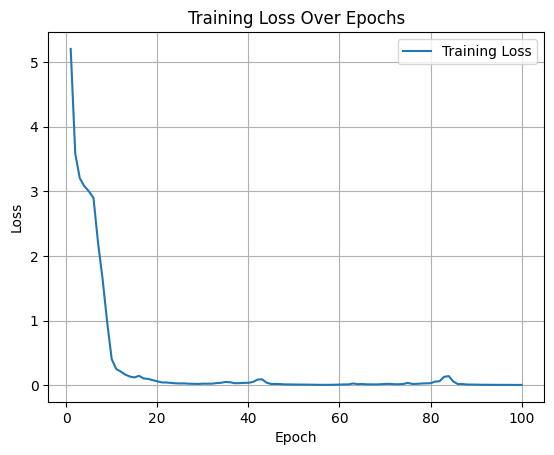

In [11]:
# Plot the loss graph
plt.plot(range(1, epoch_num + 1), graph_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Evaluation
model.eval()
total_loss = 0
with torch.no_grad():
    for batch_x, batch_y in test_data_loader:
        outputs = model(batch_x)
        loss = loss_fn(outputs, batch_y.float().unsqueeze(1))
        total_loss += loss.item()

print(f"Test Loss: {total_loss}")

Test Loss: 0.29573648143559694


In [23]:
# Compute accuracy on new set of test samples by running predictions
N = 100
test_x, test_y = prepare_data(N, 64, 128)

# Pad sequences in test_x
max_len = max(len(seq) for seq in test_x)
padded_test_x = [seq + [0] * (max_len - len(seq)) for seq in test_x]

# Convert data to PyTorch tensors
test_x = torch.tensor(padded_test_x)
test_y = torch.tensor(test_y)

# Run predictions for each sequence and compute overall accuracy
correct_predictions = 0
for sequence, y in zip(test_x, test_y):
    # Perform inference
    with torch.no_grad():
        output = model(sequence.unsqueeze(0))
    # Convert output to CpG count
    predicted_cpg_count = output.item()
    # Check if prediction is within a tolerance of 0.5
    if abs(predicted_cpg_count - (y.float().unsqueeze(0))) <= 0.3:
        correct_predictions += 1

# Compute overall accuracy
accuracy = correct_predictions / N
print("Overall Accuracy:", accuracy)

Overall Accuracy: 0.9


In [15]:
torch.save(model.state_dict(), "model_var_len.pth")

In [35]:
import random
seq_len = 67
# Define the list of characters
nucleotides = ['N', 'A', 'C', 'G', 'T']

# Generate a random sequence of 128 characters
random_sequence = ''.join(random.choice(nucleotides) for _ in range(seq_len))

print(random_sequence)
print(count_cpgs(random_sequence))

TNGACTGCGNNACNTCATCAGNACGGNGGCCCNCAAAGTNTNTGATTGTGCTCNNTTTGANNNCNGT
2
